In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('air+quality/AirQualityUCI.csv', sep=';')

# keep only the columns with sensors
df = df.filter(regex='S\d')
df = df.replace(-200, None)

# show columns with missing values and their number in a dataframe 
missing_values = df.isin([None]).sum()
missing_values

PT08.S1(CO)      366
PT08.S2(NMHC)    366
PT08.S3(NOx)     366
PT08.S4(NO2)     366
PT08.S5(O3)      366
dtype: int64

In [3]:
# for every column which has at least a missing value
for column in df.columns[df.isin([None]).any()]:
    
    # imputation: mean between next and previous value
    df[column] = df[column].astype(float).interpolate()
    
    # assert that there are no missing values
    df[column] = (df[column] - df[column].mean()) / df[column].std()
    
# assert that there are no missing values 
assert df.isin([None]).sum().sum() == 0


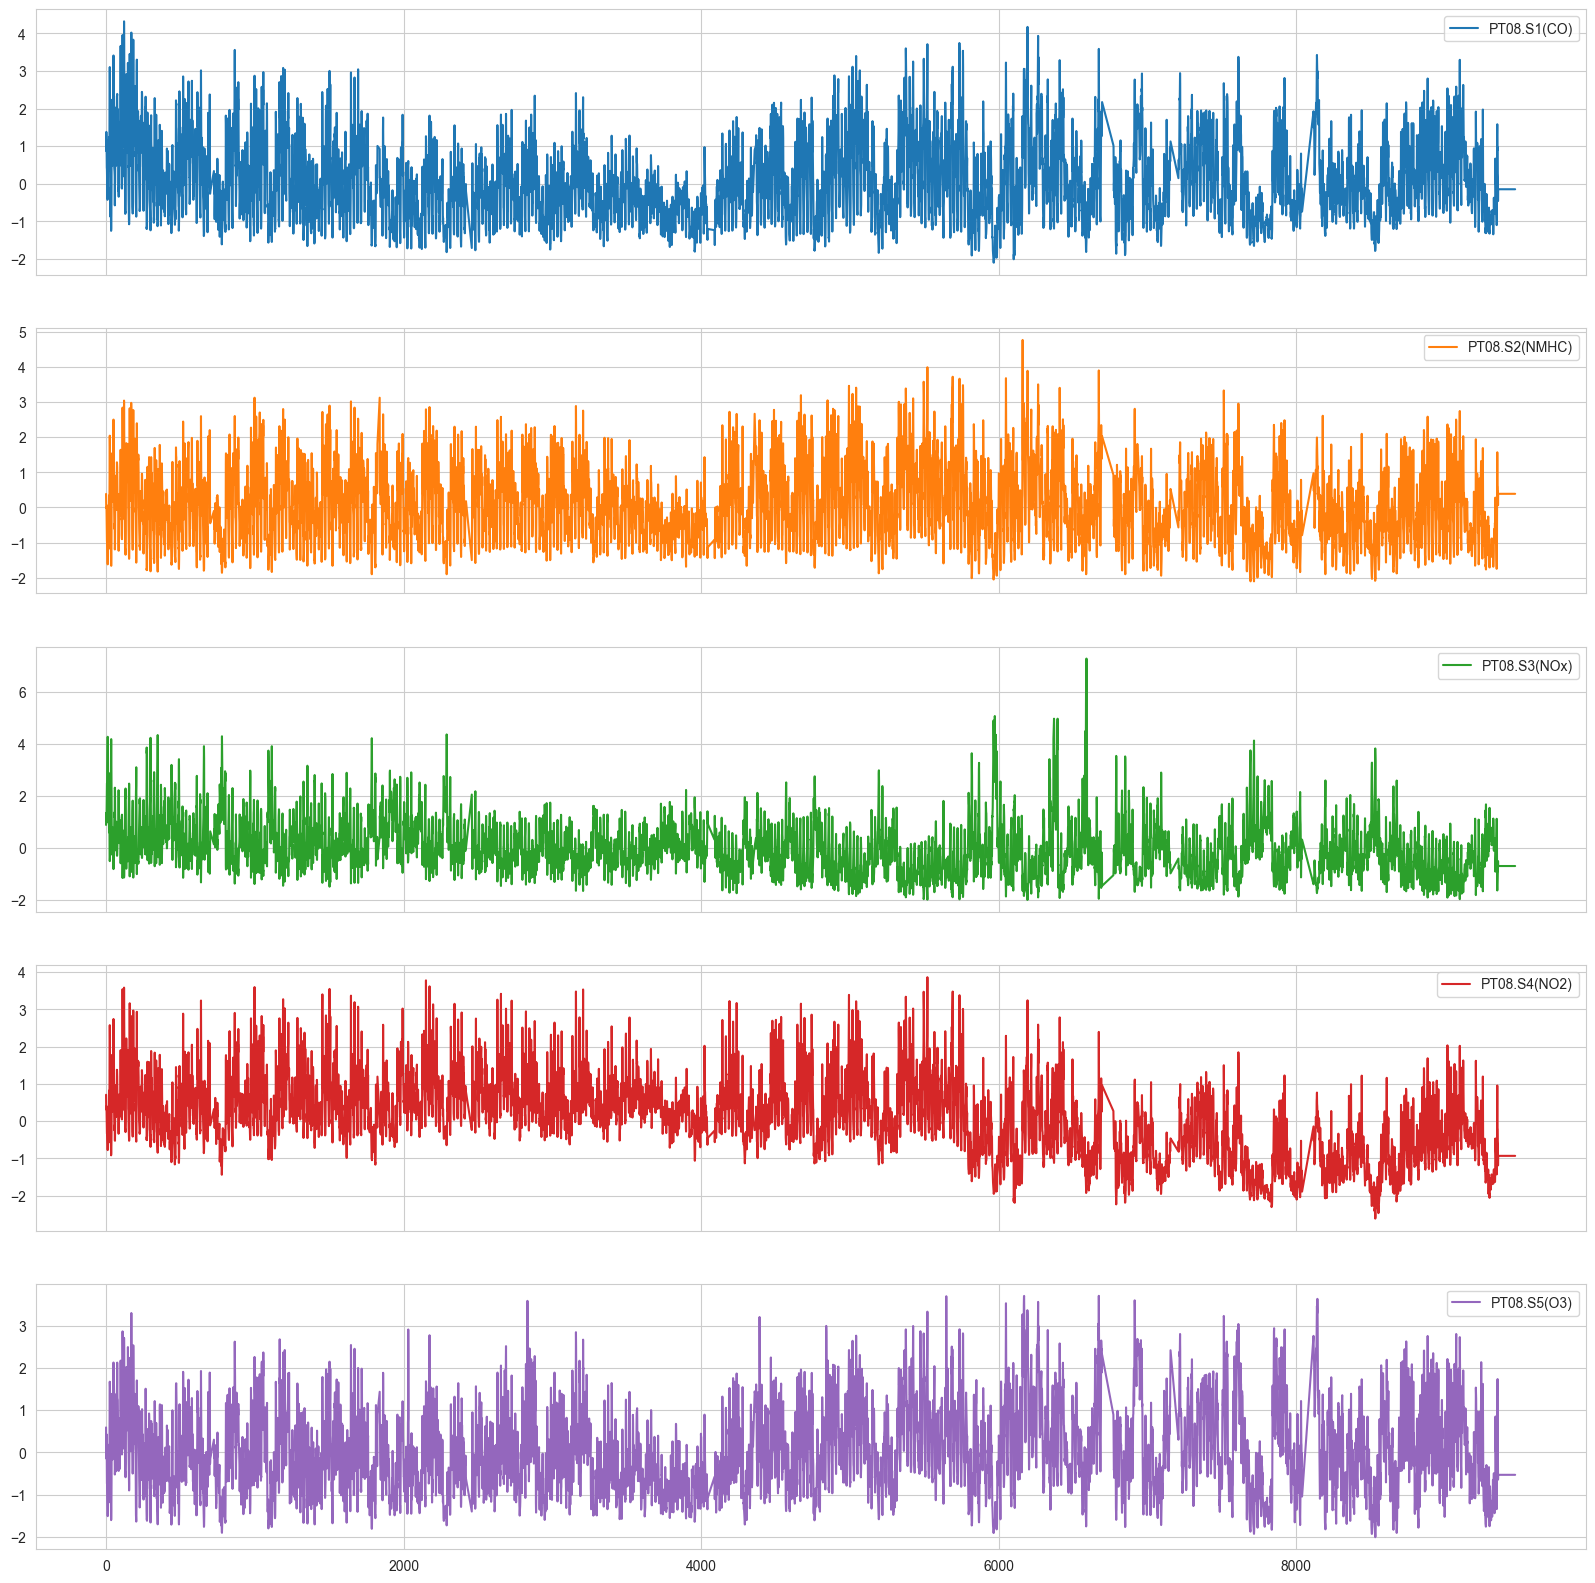

In [ ]:
df.plot(subplots=True, figsize=(20, 20))
plt.show()

In [5]:
def cross_correlation(x, y, lag):
    return x.corr(y.shift(lag))

def normalized_cross_correlation(x, y, lag):
    return cross_correlation(x, y, lag) / (np.linalg.norm(x) * np.linalg.norm(y))

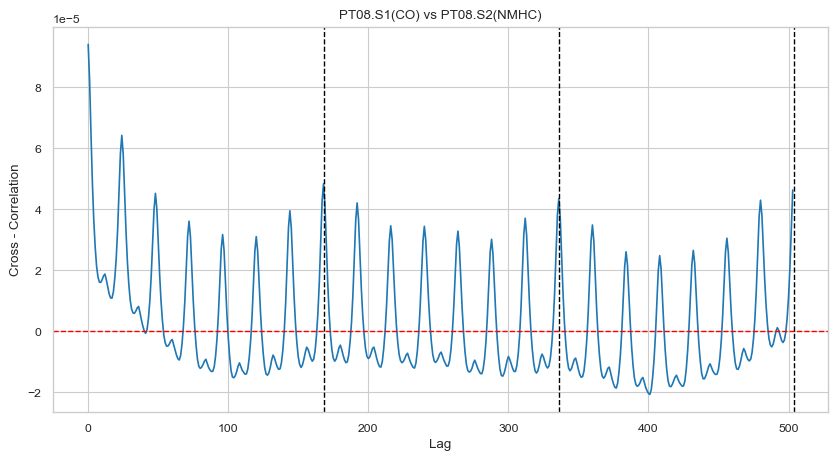

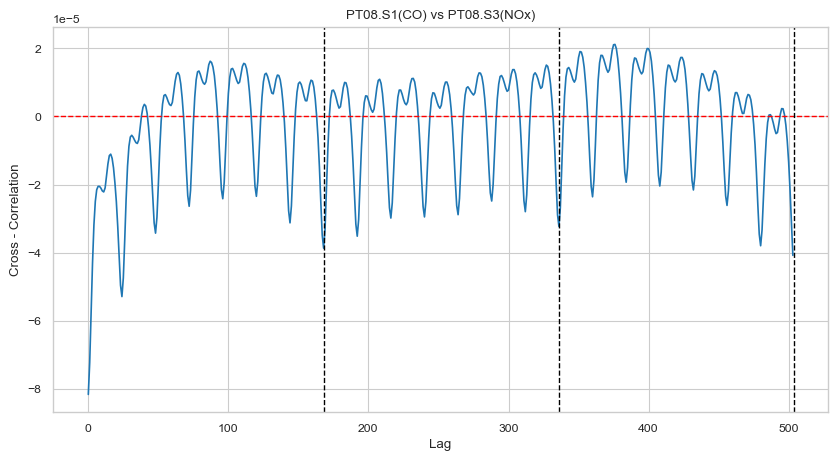

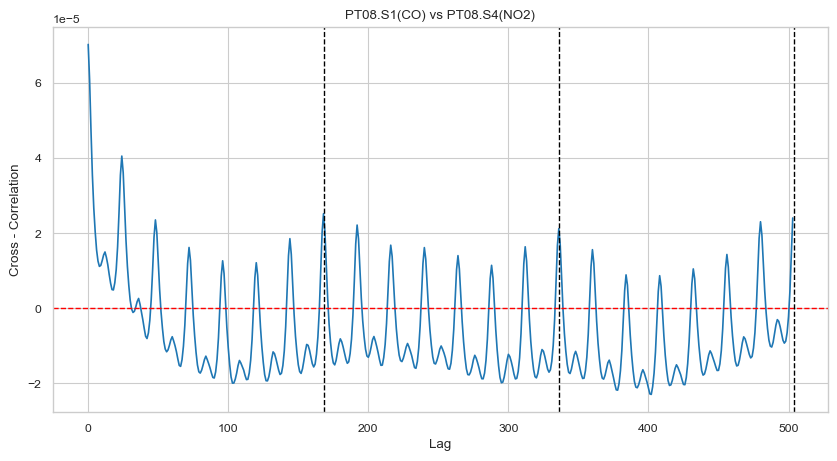

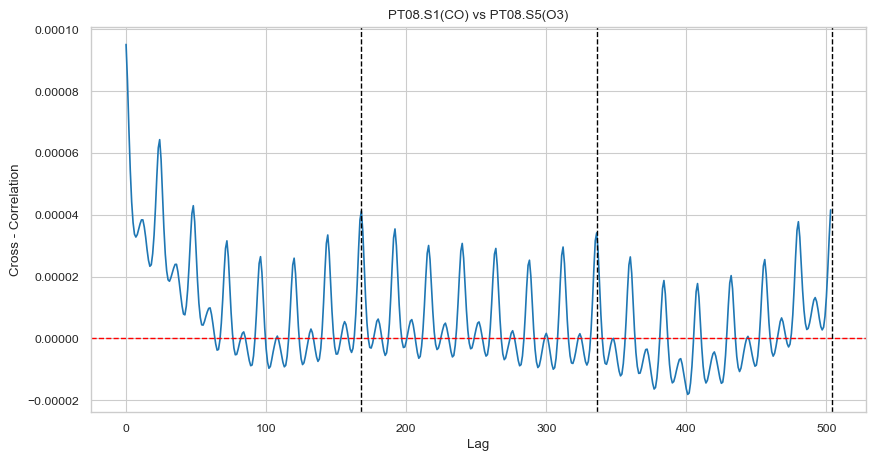

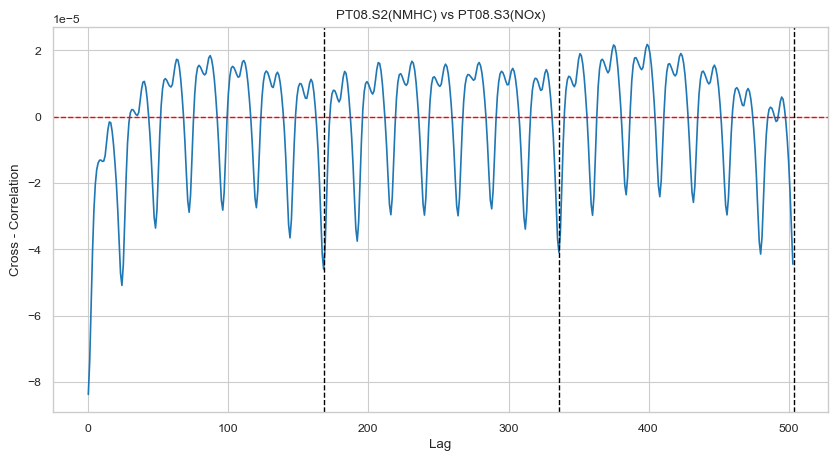

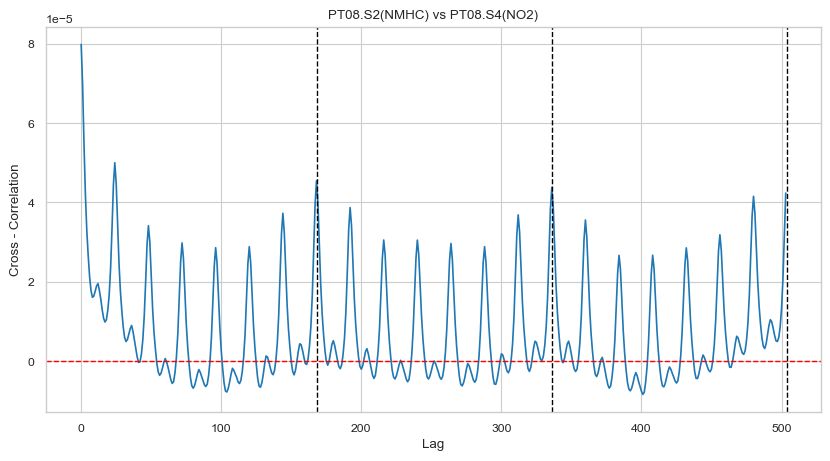

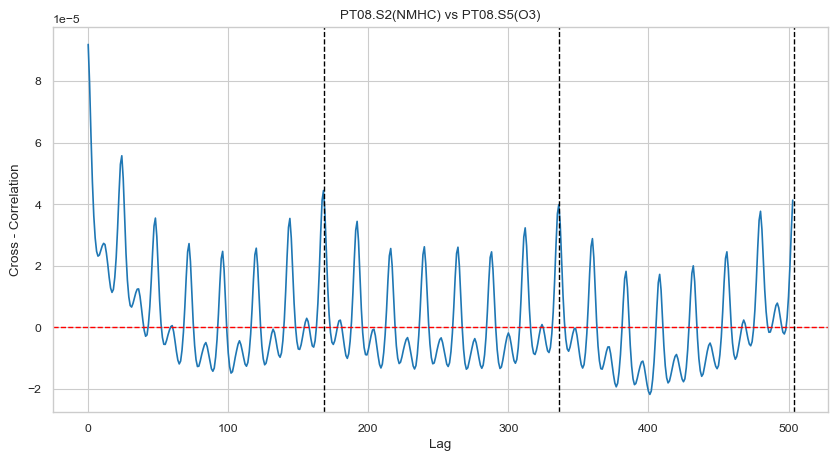

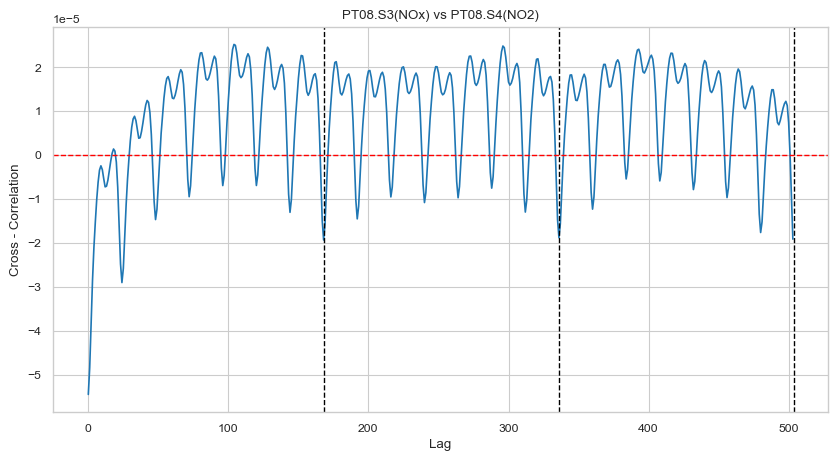

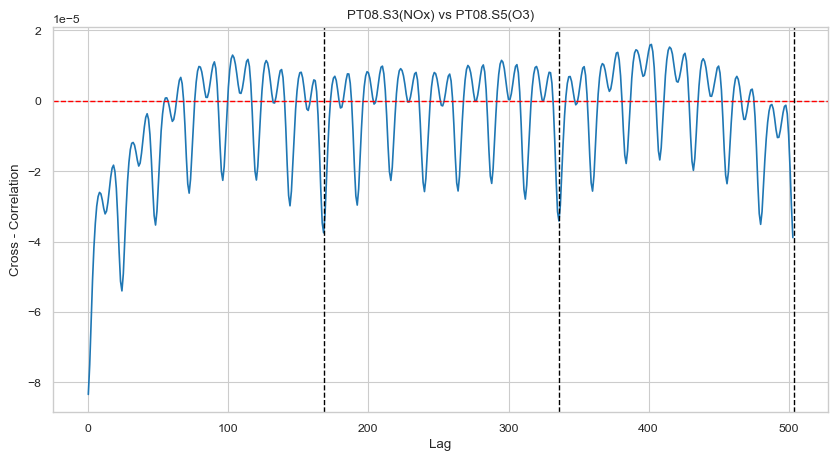

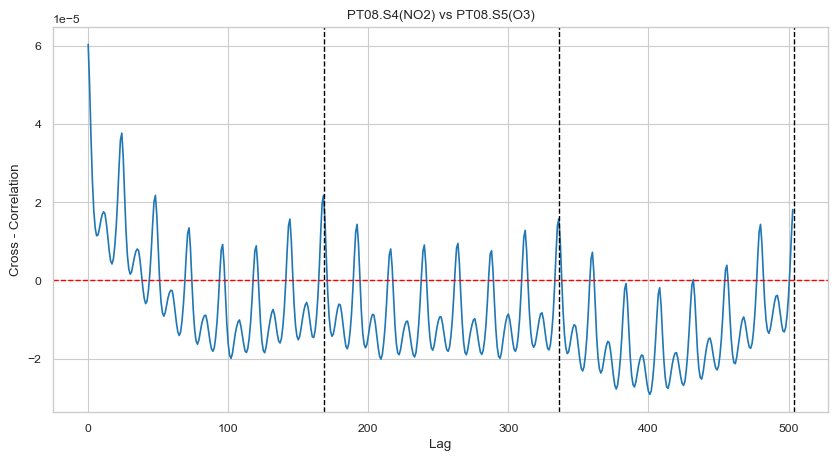

In [7]:
import seaborn as sns

week_hours = 7 * 24
num_weeks = 3
taus = range(0, num_weeks * week_hours)

correlations = []

for i, column1 in enumerate(df.columns):
    for j, column2 in enumerate(df.columns):
        if column1 == column2 or i > j:
            continue
        correlations = [normalized_cross_correlation(df[column1], df[column2], tau) for tau in taus]
        # plot with seaborn
        plt.figure(figsize=(10, 5))
        sns.set_context('paper')
        sns.set_style('whitegrid')
        sns.lineplot(x=taus, y=correlations)
        plt.title(f'{column1} vs {column2}')
        plt.xlabel('Lag')
        plt.ylabel('Cross - Correlation')
        plt.axhline(0, color='red', lw=1, linestyle='--')
        # from the second week to the end of the third week
        for k in range(1, num_weeks + 1):
            plt.axvline(k * week_hours, color='black', lw=1, linestyle='--')
        plt.show()
        plt.close()
